# Data description

Firstly , importing all the required libraries and displaying the features of the dataset.

In [1]:
# Imported the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

In [2]:
# Loaded the dataset
data_dir = '/Users/rohangarakurthi/Downloads/Dataset'
!ls {data_dir}

Bus        Car        Truck      motorcycle


In [3]:
# Defined a function to calculate number of classes and total number of images
def load_metadata(dir_path):
    
    rows = []
    for dir_path, dir_name, file_list in os.walk(dir_path):
        for file in file_list:
            file_path = os.path.join(dir_path, file)
            label = os.path.split(dir_path)[-1]
            rows.append([file_path, label])
            
    return pd.DataFrame(rows, columns=['image_path', 'class'])

In [4]:
# Printing the number of images and classes
img_df = load_metadata(data_dir)
print("number of images present in the dataset:", img_df.shape[0])
print("number of classes:", len(img_df['class'].unique()))

number of images present in the dataset: 400
number of classes: 4


Visualized the dataset with bar graph

<Axes: title={'center': 'distribution of classes in the dataset'}, xlabel='class'>

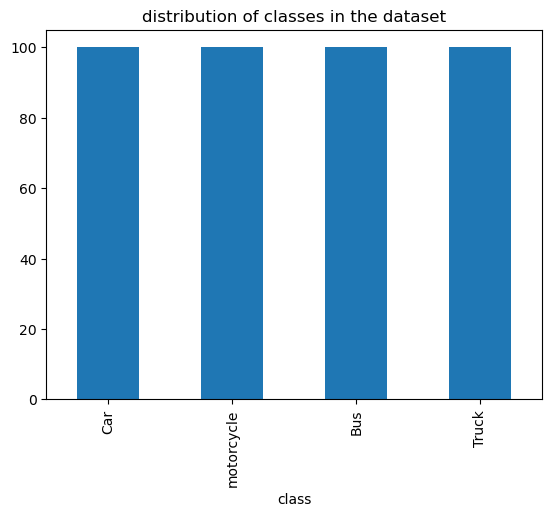

In [5]:
# Showing equal distribution of images for each class using a bar graph
img_df['class'].value_counts().plot(kind="bar", 
        title="distribution of classes in the dataset")

- All four classes are equally distributed.

In [6]:
img_nd_labels = img_df.values
img_nd_labels[0]

array(['/Users/rohangarakurthi/Downloads/Dataset/Car/Image_15.jpg', 'Car'],
      dtype=object)

In [7]:
# Splitting the dataset images into training and testing 
from sklearn.model_selection import train_test_split
train_val_data, test_data = train_test_split(img_df, train_size=0.8, random_state=45)
train_val_data.shape, test_data.shape

((320, 2), (80, 2))

In [8]:
train_val_data['class'].value_counts() # Counting the number of images in training dataset in each class

class
motorcycle    81
Truck         81
Car           81
Bus           77
Name: count, dtype: int64

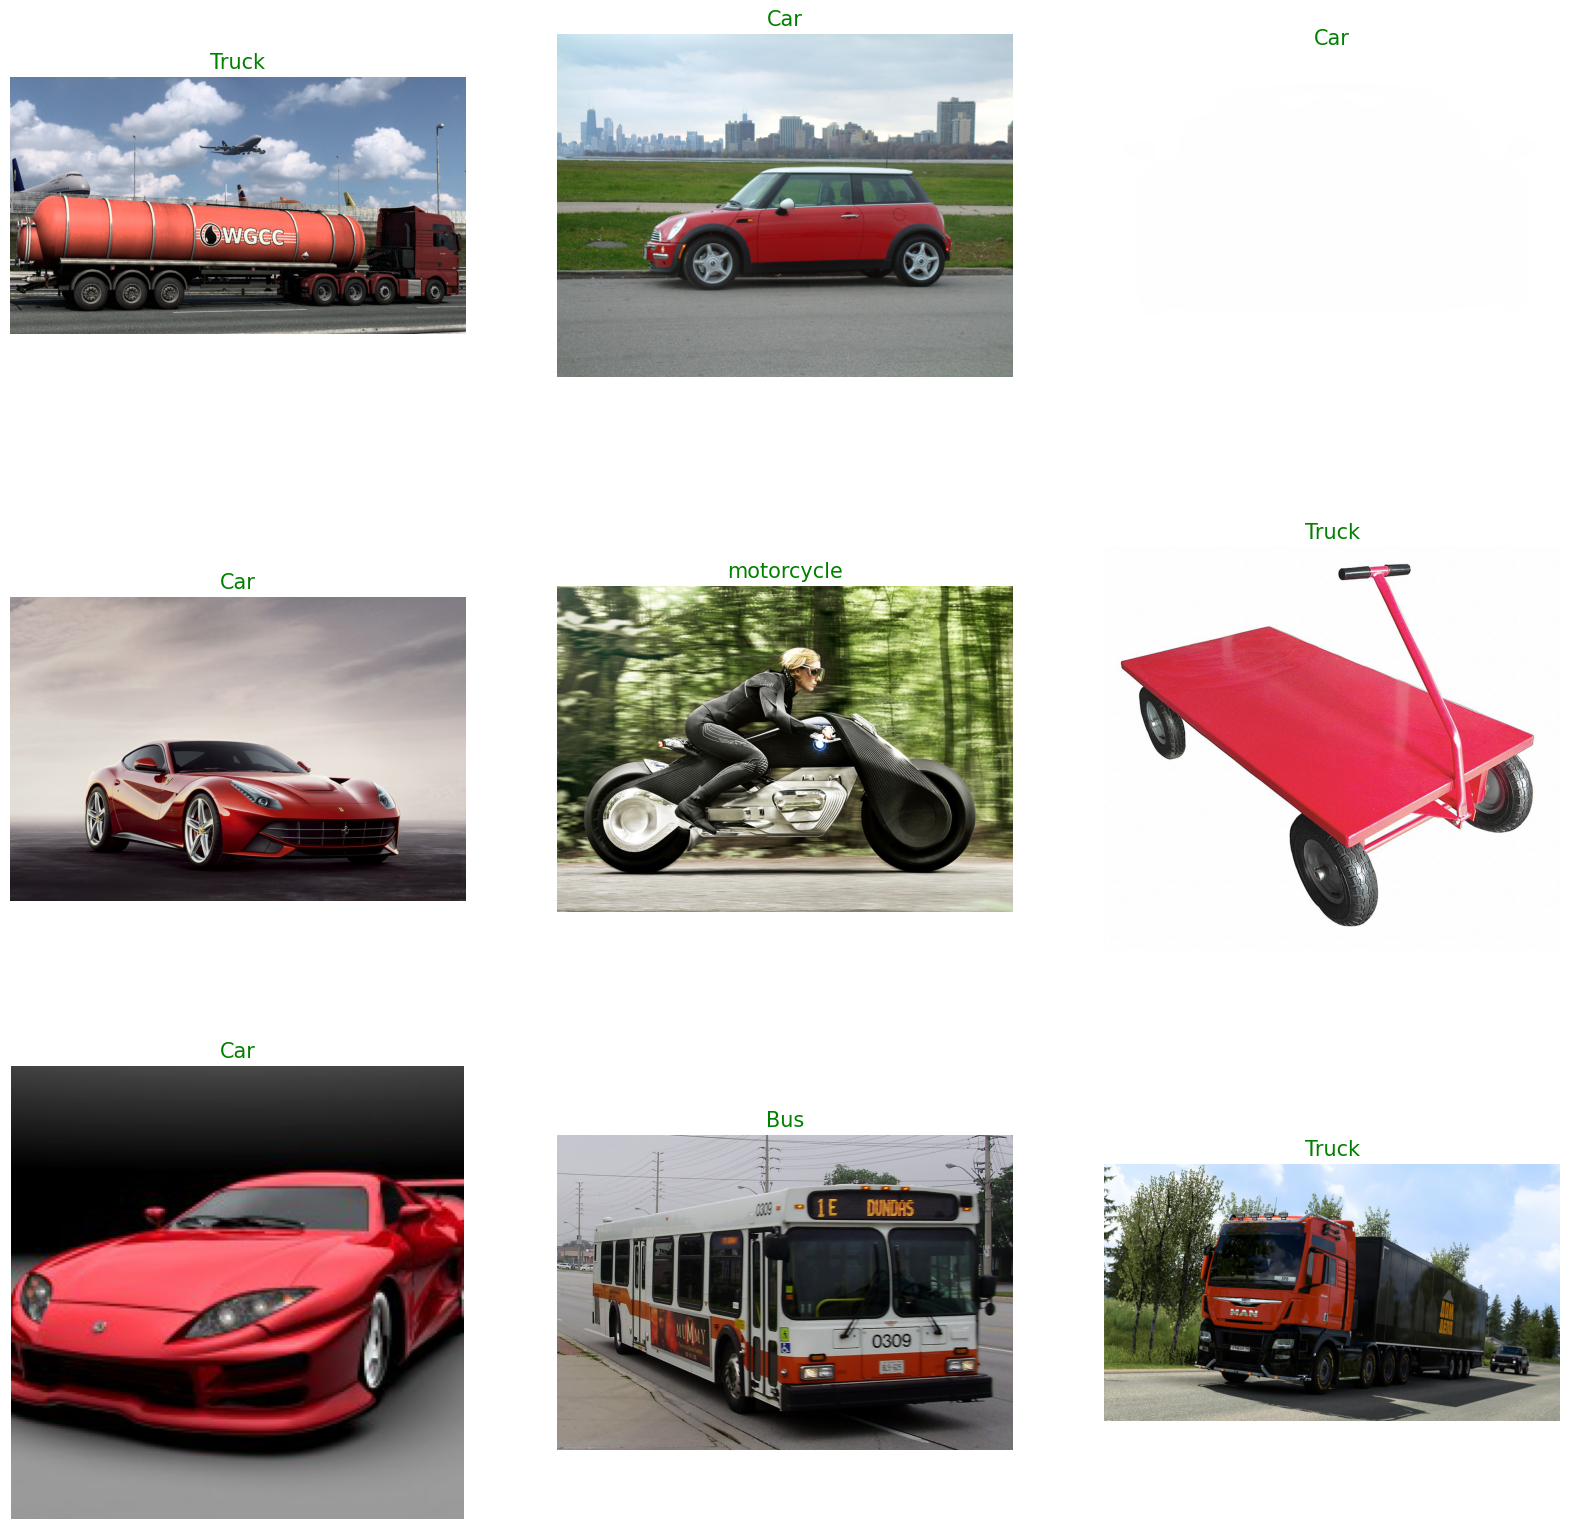

In [9]:
# Showing a sample image output to understand a image of each class
sample_img_paths, sample_labels = zip(*img_df.sample(9, random_state=321).values.tolist())

plt.figure(figsize= (20, 20))
for i in range(9):
    # create a subplot grid
    plt.subplot(3, 3, i + 1)
    image = plt.imread(sample_img_paths[i])                               
    image = image/255
    plt.imshow(image)
    # get name of class/label
    class_name = sample_labels[i]   
    plt.title(class_name, fontsize= 15, color= 'green')
    plt.axis('off')
    
plt.show()  # As you can see that one image contains no picture but labeled as a car, this is just to show that the final web app understands that the picture contains nothing.

# Exploratory Data Analysis

# Data Augumentation

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

image shape: (554, 984, 3)


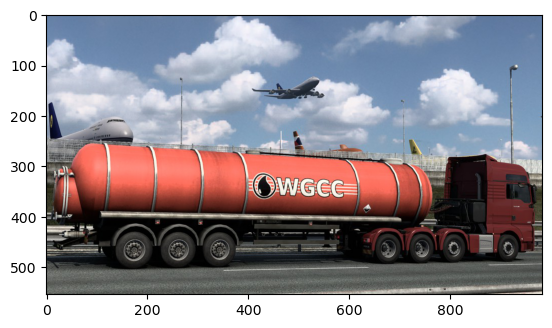

In [11]:
# Augumentation of data by showing on a picture using axis
sample_img_path, sample_label = zip(*img_df.sample(1, random_state=321).values.tolist())
image = plt.imread(sample_img_path[0])
print("image shape:", image.shape)
plt.imshow(image)

In [12]:
# Defining a function to compare the augumented image with the original image
def visualize_images(org_img, aug_img):
    
    fig = plt.figure()
    
    plt.subplot(1,2,1)
    plt.imshow(org_img)
    plt.title('Original image')
    
    plt.subplot(1,2,2)
    plt.imshow(aug_img)
    plt.title('Augmented image')

#### Data Augumentation using tf image

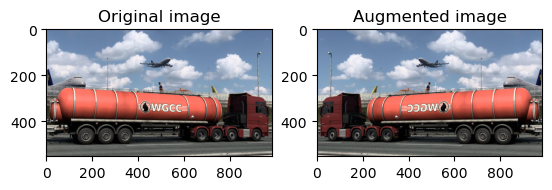

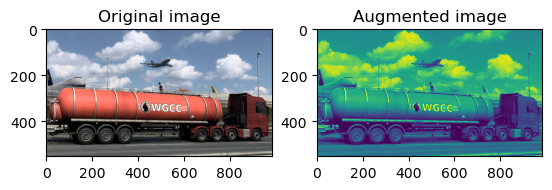

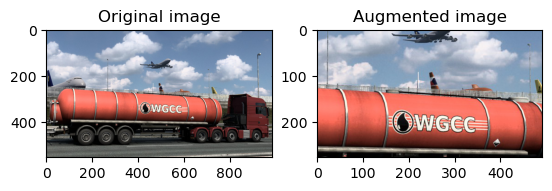

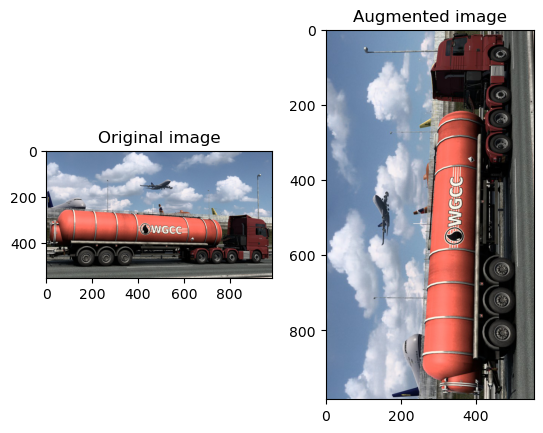

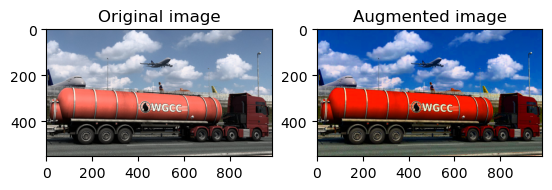

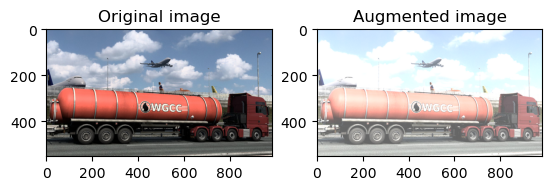

In [13]:
# Augumenting the data using all methods
image = plt.imread(sample_img_path[0])

flipped = tf.image.flip_left_right(image) # using flipped
visualize_images(image, flipped)

grayscaled = tf.image.rgb_to_grayscale(image)  # using grayscale
visualize_images(image, tf.squeeze(grayscaled))

cropped = tf.image.central_crop(image, central_fraction=0.5)   # By cropping the image
visualize_images(image, cropped)

rotated = tf.image.rot90(image)
visualize_images(image, rotated)               # Using picture rotation

saturated = tf.image.adjust_saturation(image, 3)         # using saturation
visualize_images(image, saturated)

bright = tf.image.adjust_brightness(image, 0.4)          # Using brightness of the image
visualize_images(image, bright)

Tried different augumentation to show all the methods and displyed them

#### Data augmentation using tf layers

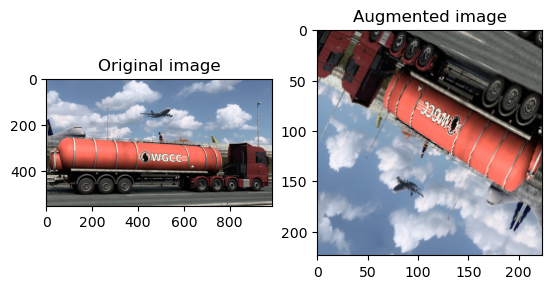

In [14]:
# This code shows that this augumentation suits to use the model
IMG_SIZE = 224

data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

image = plt.imread(sample_img_path[0])
augmented_image = data_augmentation(image)
visualize_images(image, augmented_image)

# Model Training

#### Baseline Model

In [16]:
# Applying a Baseline CNN model to test the trainable parameters
from PIL import Image

unique_label = sorted(img_df['class'].unique())
label_map = dict(zip(unique_label, range(0,len(unique_label))))

def load_data(data_df):
    
    # data_df['image_path']
    images_arr = []
    label_arr = []
    for img_path, label in data_df.values:
        img_arr = plt.imread(img_path)
        # print(img_arr.shape)
        img = Image.fromarray((img_arr * 255).astype(np.uint8))
        img = img.resize(size=(224, 224)).convert('RGB')
        # print(np.array(img).shape)
        images_arr.append(np.array(img))
        label_arr.append(label_map[label])

    return np.array(images_arr), np.array(label_arr)

In [17]:
num_classes = 4

model = tf.keras.Sequential([                         # applying the model
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

Took a baseline model of CNN and then used to train the model.

In [18]:
# Calculating the model summary of each hyperparameter
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape=(None,224,224,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 64)                12845120  
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                      

Here in the above table shows the output of each parameter of the model sequential which is CNN and displayed them to find which are used for training the dataset.

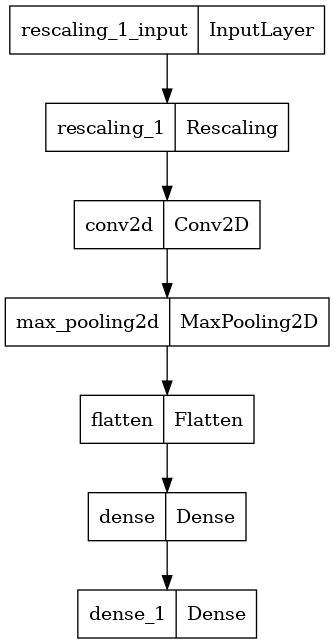

In [20]:
tf.keras.utils.plot_model(model,     show_shapes=False,                 # this is a flow chart to show how the model processes on the training dataset
    show_dtype=False,)

Now, a simple flow chart output to show the actual process which will happen with the model

In [19]:
X_train, y_train = load_data(test_data)
X_test, y_test = load_data(test_data)

In [20]:
res = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),                      # Fitting the model on the training dataset and we can see that in each epoch the accuracy got increased
                epochs=5)

Epoch 1/5
3/3 [==============================] - 0s 151ms/step - loss: 16.5050 - accuracy: 0.2625 - val_loss: 21.7128 - val_accuracy: 0.2375
Epoch 2/5
3/3 [==============================] - 0s 90ms/step - loss: 15.0242 - accuracy: 0.1875 - val_loss: 3.0047 - val_accuracy: 0.2375
Epoch 3/5
3/3 [==============================] - 0s 95ms/step - loss: 2.8273 - accuracy: 0.2375 - val_loss: 1.1958 - val_accuracy: 0.4625
Epoch 4/5
3/3 [==============================] - 0s 92ms/step - loss: 1.2663 - accuracy: 0.4625 - val_loss: 1.4406 - val_accuracy: 0.4250
Epoch 5/5
3/3 [==============================] - 0s 91ms/step - loss: 1.3551 - accuracy: 0.4500 - val_loss: 0.8812 - val_accuracy: 0.6625


Now, fitting the model with an epoch with 5 stages and found that the accuracy changed very much from 1 to 5. And next, plotting the graph for loss function and accuracy.

# Comparison for loss function with epoch with plotting graphs

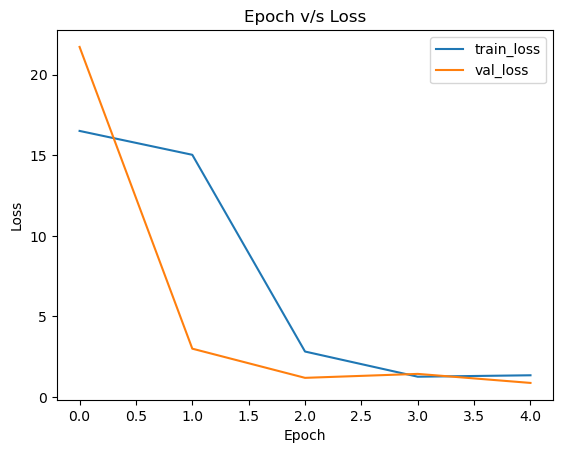

In [21]:
# Comparing the results of training and validating 
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch v/s Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

From the graph we can see that the loss function got decreased as the epoch got increased.

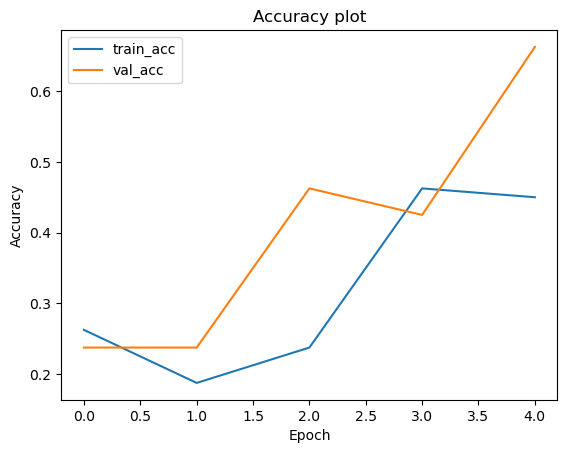

In [22]:
# Same with the accuracy 
plt.plot(res.history['accuracy'])
plt.plot(res.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.legend(['train_acc', 'val_acc'])
plt.show()

Same with the accuracy as the epoch got increased, the accuracy also increased.

- The images in the datasets looks too graphic and very different to real world. Hence the model will not perform well when asked to predict on real world data. Also, there are only 4 vechile types in this dataset. We can overcome these problems by extending the dataset.

### Next Step: Extending Data & Classes
- Add more images into 4 existing classes of datasets to improve the quality of the dataset and the machine learning model.
- Extend classes available by finding more data, to add other vehicle types like airplane & train.
- Add some random non-vehicle images to a class named "non-vehicle" so that models knows when a vehicle is not present in the given input.
- Compare the performance of different pretrained models.

#### Additional datasets under consideration: 
- https://www.kaggle.com/datasets/dataclusterlabs/indian-vehicle-dataset
- https://www.kaggle.com/datasets/maciejgronczynski/vehicle-classification-dataset
- https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set

#### References:

- Data Augumentation using Tensorflow, https://www.tensorflow.org/tutorials/images/data_augmentation
- Image plotting with matplotlib, https://matplotlib.org/stable/tutorials/images.html